In [1]:
import numpy as np
import torch
print(torch.__version__)

np.random.seed(42)

0.4.1


In [2]:
class Layer:
    def __init__(self):
        pass
    
    def forward(self, input):
        pass
    
    def backward(self, input, grad_output):
        pass

In [3]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        output = torch.max(input, torch.tensor([0.], device='cpu'))
        return output

In [4]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = torch.randn(input_units, output_units, device='cpu', requires_grad=True)*0.01
        self.biases  = torch.ones(output_units, device='cpu', requires_grad=True)
        
    def forward(self,input):
        return torch.matmul(input, self.weights) + self.biases
    
    def backward(self, w_grad, b_grad):
        self.weights = self.weights - self.learning_rate * w_grad
        self.biases  = self.biases - self.learning_rate * b_grad

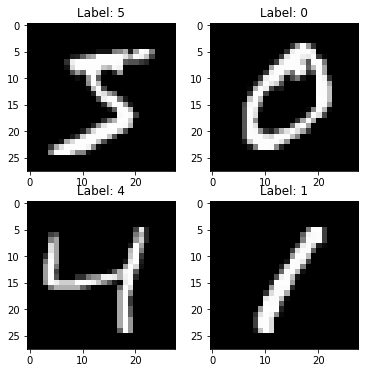

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [7]:
X_train = torch.from_numpy(X_train).float().to('cpu')
X_train.requires_grad_(True)

X_val = torch.from_numpy(X_val).float().to('cpu')
X_val.requires_grad_(True)

X_test = torch.from_numpy(X_test).float().to('cpu')
X_test.requires_grad_(True)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)

In [163]:
def forward(network, X):
    activations = []
    input       = X
    
    for layer in network:
        input = layer.forward(input)
        activations.append(input)
        
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    logits = forward(network, X)[-1]
    return logits.cpu().detach().numpy().argmax(axis=-1)

def normalize(vec, c):
    norm = torch.norm(vec)
    
    if norm >= c:
        return (c * vec) / norm
    else:
        return vec

### LRA-diff

In [164]:
def train(network,X,y):
    
    # parameters
    K        = 5
    beta     = .001
    n_layers = len(network) // 2 + 1
    layer    = n_layers
    c        = 1
    
    # forward pass
    act = forward(network, X)
    
    pre_activations      = act[::2] # h
    pre_activations_tmp  = pre_activations.copy() # h_hat

    post_activations     = [X] + act[1::2] # z
    layer_post_target    = post_activations.copy() # y_z
    post_activations_tmp = post_activations.copy() # z_hat

    layer_post_target    = layer_post_target + [torch.from_numpy(y).long().to('cpu')]
    W_grads              = []
    b_grads              = []
    
    for l in range(len(network) - 1, 0, -2):
        W                   = torch.from_numpy(network[l].weights.cpu().detach().numpy()).to('cpu')
        W.requires_grad_(True)
        
        b                   = torch.from_numpy(network[l].biases.cpu().detach().numpy()).to('cpu')
        b.requires_grad_(True)
        
        z_l_1                = torch.from_numpy(post_activations[layer-1].cpu().detach().numpy()).to('cpu') # z_(l-1)
        z_l_1.requires_grad_(True)
        
        z_l                  = torch.matmul(z_l_1, W) + b # z_l
        
        if l == len(network) - 1: 
            loss = torch.functional.F.nll_loss(z_l, layer_post_target[layer])
        else:
            mse_loss = torch.nn.MSELoss()
            loss     = mse_loss(z_l, layer_post_target[layer])
            
        loss.backward(retain_graph=True)
        
        w_grad = normalize(W.grad, c)
        b_grad = normalize(b.grad, c)

        W_grads.append(w_grad)
        b_grads.append(b_grad)
        
        # zero out gradients
        W.grad.zero_()
        b.grad.zero_()
        
        for k in range(K):
            h_l_1  = torch.from_numpy(pre_activations[layer-2].cpu().detach().numpy()).to('cpu')
            h_l_1.requires_grad_(True)

            z_l_1  = network[l-1].forward(h_l_1)
            z_l    = torch.matmul(z_l_1, W) + b
            
            if l == len(network) - 1:
                loss   = torch.functional.F.nll_loss(z_l, layer_post_target[layer])
            else:
                loss = torch.nn.MSELoss()
                loss = mse_loss(z_l, layer_post_target[layer])
            
            loss.backward(retain_graph=True)    
            h_l_1_grad            = h_l_1.grad
            
            # normalize h_l_1_grad
            h_l_1_grad = normalize(h_l_1_grad, c)
            
            # updates
            pre_activations[layer-2]  = h_l_1 - beta * h_l_1_grad
            post_activations[layer-1] = network[l-1].forward(pre_activations[layer-2])
            pre_activations[layer-1]  = torch.matmul(z_l_1, W) + b
            
            h_l_1.grad.zero_() # zero out gradients

#             if layer != n_layers-1:
#                 post_activations[layer-1] = network[l].forward(pre_activations[layer-1])
        
        layer_post_target[layer-1] = post_activations[layer-1]
        layer -= 1
    
        
    return W_grads[::-1], b_grads[::-1]

In [165]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [172]:
from IPython.display import clear_output
train_log = []
val_log = []

In [173]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 10))

In [174]:
for epoch in range(2):
    print('*' * 100)
    print(network[-1].weights[:10])
        
    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        
        W_grads, b_grads = train(network, x_batch, y_batch)
        layer    = 0
        
        for l in range(2, len(network), 2):
            network[l].backward(W_grads[layer], b_grads[layer])
            layer += 1
    
    print()
    print(network[-1].weights[:10])
        
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
#     clear_output()
#     print("Epoch",epoch)
#     print("Train accuracy:",train_log[-1])
#     print("Val accuracy:",val_log[-1])
#     plt.plot(train_log,label='train accuracy')
#     plt.plot(val_log,label='val accuracy')
#     plt.legend(loc='best')
#     plt.grid()
#     plt.show()
    

  1%|          | 14/1562 [00:00<00:11, 135.82it/s]

****************************************************************************************************
tensor([[ 0.0010,  0.0153,  0.0019, -0.0027, -0.0112, -0.0149, -0.0089, -0.0063,
          0.0070, -0.0091],
        [ 0.0029,  0.0206,  0.0009, -0.0133, -0.0054, -0.0060, -0.0025,  0.0008,
          0.0107, -0.0115],
        [-0.0073,  0.0179, -0.0159,  0.0170,  0.0047,  0.0011,  0.0069,  0.0126,
          0.0193,  0.0104],
        [-0.0046, -0.0135,  0.0012,  0.0107,  0.0106,  0.0015, -0.0012, -0.0063,
         -0.0076,  0.0025],
        [ 0.0078, -0.0043,  0.0216, -0.0168,  0.0042,  0.0143, -0.0182, -0.0004,
          0.0041,  0.0085],
        [ 0.0083, -0.0045, -0.0156,  0.0046,  0.0101,  0.0081, -0.0102, -0.0042,
          0.0006,  0.0060],
        [-0.0148,  0.0040,  0.0096,  0.0136, -0.0018,  0.0040,  0.0085, -0.0266,
          0.0046, -0.0090],
        [ 0.0062,  0.0019, -0.0083,  0.0001, -0.0128,  0.0093, -0.0004,  0.0035,
         -0.0026,  0.0045],
        [-0.0056,  0.0148, 

100%|██████████| 1562/1562 [00:12<00:00, 121.49it/s]



tensor([[3.1324, 3.6260, 3.1680, 3.2393, 3.0771, 2.8488, 3.1505, 3.2793, 3.0825,
         3.1676],
        [2.8947, 3.3530, 2.9242, 2.9807, 2.8439, 2.6380, 2.9106, 3.0315, 2.8515,
         2.9193],
        [3.5321, 4.1009, 3.5622, 3.6784, 3.4931, 3.2394, 3.5757, 3.7254, 3.4987,
         3.6016],
        [3.1344, 3.6100, 3.1779, 3.2623, 3.1076, 2.8734, 3.1684, 3.2892, 3.0775,
         3.1880],
        [3.5959, 4.1307, 3.6484, 3.6952, 3.5376, 3.2960, 3.5987, 3.7613, 3.5290,
         3.6469],
        [2.8391, 3.2605, 2.8467, 2.9360, 2.8008, 2.5984, 2.8449, 2.9667, 2.7829,
         2.8783],
        [3.2315, 3.7496, 3.2936, 3.3750, 3.1987, 2.9742, 3.2843, 3.3791, 3.1951,
         3.2842],
        [2.7459, 3.1594, 2.7600, 2.8336, 2.6867, 2.5144, 2.7602, 2.8757, 2.6893,
         2.7828],
        [2.6524, 3.0775, 2.6853, 2.7598, 2.6260, 2.4318, 2.6815, 2.7785, 2.6110,
         2.6786],
        [2.9420, 3.3970, 2.9650, 3.0533, 2.9089, 2.6922, 2.9472, 3.0932, 2.9119,
         2.9878]], grad_fn=

  1%|          | 11/1562 [00:00<00:14, 106.97it/s]

****************************************************************************************************
tensor([[3.1324, 3.6260, 3.1680, 3.2393, 3.0771, 2.8488, 3.1505, 3.2793, 3.0825,
         3.1676],
        [2.8947, 3.3530, 2.9242, 2.9807, 2.8439, 2.6380, 2.9106, 3.0315, 2.8515,
         2.9193],
        [3.5321, 4.1009, 3.5622, 3.6784, 3.4931, 3.2394, 3.5757, 3.7254, 3.4987,
         3.6016],
        [3.1344, 3.6100, 3.1779, 3.2623, 3.1076, 2.8734, 3.1684, 3.2892, 3.0775,
         3.1880],
        [3.5959, 4.1307, 3.6484, 3.6952, 3.5376, 3.2960, 3.5987, 3.7613, 3.5290,
         3.6469],
        [2.8391, 3.2605, 2.8467, 2.9360, 2.8008, 2.5984, 2.8449, 2.9667, 2.7829,
         2.8783],
        [3.2315, 3.7496, 3.2936, 3.3750, 3.1987, 2.9742, 3.2843, 3.3791, 3.1951,
         3.2842],
        [2.7459, 3.1594, 2.7600, 2.8336, 2.6867, 2.5144, 2.7602, 2.8757, 2.6893,
         2.7828],
        [2.6524, 3.0775, 2.6853, 2.7598, 2.6260, 2.4318, 2.6815, 2.7785, 2.6110,
         2.6786],
        

100%|██████████| 1562/1562 [00:15<00:00, 103.32it/s]



tensor([[6.0556, 7.0011, 6.1324, 6.2698, 5.9653, 5.5276, 6.1019, 6.3546, 5.9672,
         6.1323],
        [5.7747, 6.6776, 5.8447, 5.9665, 5.6887, 5.2768, 5.8179, 6.0602, 5.6936,
         5.8389],
        [7.1879, 8.3210, 7.2695, 7.4683, 7.1051, 6.5889, 7.2678, 7.5715, 7.1072,
         7.3092],
        [6.0624, 6.9919, 6.1483, 6.2985, 6.0010, 5.5570, 6.1256, 6.3702, 5.9675,
         6.1580],
        [7.2963, 8.4005, 7.3998, 7.5306, 7.1923, 6.6857, 7.3348, 7.6531, 7.1803,
         7.3984],
        [5.6533, 6.5084, 5.7000, 5.8534, 5.5809, 5.1770, 5.6863, 5.9272, 5.5601,
         5.7320],
        [6.3464, 7.3473, 6.4538, 6.6050, 6.2766, 5.8294, 6.4302, 6.6569, 6.2699,
         6.4445],
        [5.5606, 6.4069, 5.6132, 5.7509, 5.4670, 5.0928, 5.6017, 5.8357, 5.4667,
         5.6364],
        [5.4651, 6.3231, 5.5374, 5.6756, 5.4045, 5.0089, 5.5215, 5.7364, 5.3869,
         5.5304],
        [5.8541, 6.7602, 5.9188, 6.0731, 5.7858, 5.3607, 5.8880, 6.1570, 5.7867,
         5.9409]], grad_fn=